# 5. Selección de Modelos

In [1]:
import numpy as np

## Dataset

Definimos datos de lenguaje natural de juguete y vectorizamos el input usando bolsas de palabras.

In [2]:
training = [
    ('chinese beijing chinese', 'zh'),
    ('chinese chinese shangai', 'zh'),
    ('chinese macao', 'zh'),
    ('chinese beijing tokyo', 'zh'),
    ('chinese beijing osaka', 'zh'),
    ('tokyo japan chinese', 'ja'),
    ('tokyo japan osaka', 'ja'),
    ('osaka', 'ja'),
]

In [3]:
X_docs = np.array([doc for doc, _ in training])
y = np.array([cls for _, cls in training])

In [4]:
from sklearn.feature_extraction.text import CountVectorizer
vect = CountVectorizer()
X = vect.fit_transform(X_docs)

In [5]:
X

<8x7 sparse matrix of type '<class 'numpy.int64'>'
	with 19 stored elements in Compressed Sparse Row format>

## Validación Cruzada

- [Cross-validation: evaluating estimator performance](https://scikit-learn.org/stable/modules/cross_validation.html)

### División K-Fold

Podemos usar [K-Fold](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html) para hacer cross-validation:

In [9]:
from sklearn.model_selection import KFold

# random_state=0 -> semilla aleatoria
# n_splits -> cantidad de divisiones

kf = KFold(n_splits=4, shuffle=False, random_state=0)

for train_index, val_index in kf.split(X):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]
    print(f"TRAIN: {train_index} VAL: {val_index} {y_val}")

    #model.fit(X_train, y_train)
    #model.predict(X_val)

TRAIN: [2 3 4 5 6 7] VAL: [0 1] ['zh' 'zh']
TRAIN: [0 1 4 5 6 7] VAL: [2 3] ['zh' 'zh']
TRAIN: [0 1 2 3 6 7] VAL: [4 5] ['zh' 'ja']
TRAIN: [0 1 2 3 4 5] VAL: [6 7] ['ja' 'ja']


### División K-Fold Estratificada

Para que la división sea estratificada, usamos [StratifiedKFold](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html):

In [18]:
# Busca mantener la misma proporcion de clases que tengo en el dataset original

from sklearn.model_selection import StratifiedKFold
kf = StratifiedKFold(n_splits=3, shuffle=False, random_state=0)

for train_index, val_index in kf.split(X, y):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]
    print(f"TRAIN: {train_index} VAL: {val_index} {y_val}")

    #model.fit(X_train, y_train)
    #model.predict(X_val)

TRAIN: [2 3 4 6 7] VAL: [0 1 5] ['zh' 'zh' 'ja']
TRAIN: [0 1 4 5 7] VAL: [2 3 6] ['zh' 'zh' 'ja']
TRAIN: [0 1 2 3 5 6] VAL: [4 7] ['zh' 'ja']


C:\Users\W10\miniconda3\envs\diplodatos-ayvd\lib\site-packages\sklearn\model_selection\_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


## Búsqueda en Grilla (Grid Search)

- [Tuning the hyper-parameters of an estimator](https://scikit-learn.org/stable/modules/grid_search.html)

### Grilla de Parámetros

In [19]:
from sklearn.tree import DecisionTreeClassifier
DecisionTreeClassifier??

Init signature:
DecisionTreeClassifier(
    *,
    criterion='gini',
    splitter='best',
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    min_weight_fraction_leaf=0.0,
    max_features=None,
    random_state=None,
    max_leaf_nodes=None,
    min_impurity_decrease=0.0,
    min_impurity_split=None,
    class_weight=None,
    presort='deprecated',
    ccp_alpha=0.0,
)
Source:        
class DecisionTreeClassifier(ClassifierMixin, BaseDecisionTree):
    """A decision tree classifier.

    Read more in the :ref:`User Guide <tree>`.

    Parameters
    ----------
    criterion : {"gini", "entropy"}, default="gini"
        The function to measure the quality of a split. Supported criteria are
        "gini" for the Gini impurity and "entropy" for the information gain.

    splitter : {"best", "random"}, default="best"
        The strategy used to choose the split at each node. Supported
        strategies are "best" to choose the best split and "random" to choose
    

In [20]:
# podemos armar un pequeño diccionario

param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [1, 2],
}

Podemos listar todas las combinaciones para usarlas a mano con [ParameterGrid](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.ParameterGrid.html):

In [21]:
# ParameterGrid -> genera un iterador

from sklearn.model_selection import ParameterGrid

for params in ParameterGrid(param_grid):
    print(params)
    model = DecisionTreeClassifier(**params, random_state=0)
    #model.fit(...)
    #model.predict(...)

{'criterion': 'gini', 'max_depth': 1}
{'criterion': 'gini', 'max_depth': 2}
{'criterion': 'entropy', 'max_depth': 1}
{'criterion': 'entropy', 'max_depth': 2}


### Grilla de Parámetros + Validación Cruzada

[GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) nos sirve para hacer validación cruzada sobre una grilla de parámetros. Sklearn se encarga de todo el proceso y nos devuelve una tabla de resultados y el mejor clasificador obtenido.

La búsqueda se puede configurar de varias maneras. Por defecto la validación cruzada es estratificada.

- [scoring parameter](https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter9)

In [23]:
from sklearn.model_selection import GridSearchCV

model = DecisionTreeClassifier(random_state=0) # instancio el modelo

# cv=3 -> cantidad de Folds para la validacion cruzada

cv = GridSearchCV(model, param_grid, scoring='accuracy', cv=3)
cv.fit(X, y);

In [24]:
results = cv.cv_results_
params = results['params']
mean = results['mean_test_score']
std = results['std_test_score']
rank = results['rank_test_score']

print("crit.\tdepth\t| mean\tstd\trank")
for p, m, s, r in zip(params, mean, std, rank):
    print(f"{p['criterion']}\t{p['max_depth']}\t| {m:0.2f}\t{s:0.2f}\t{r}")
    
# obtengo un renglon por cada resultado posible
# Rank -> me dice cuales son los mokeros modelos. 1 es el mejor modelo

crit.	depth	| mean	std	rank
gini	1	| 0.50	0.14	3
gini	2	| 0.61	0.08	1
entropy	1	| 0.50	0.14	3
entropy	2	| 0.61	0.08	1


In [26]:
import pandas as pd
df = pd.DataFrame(results)
df

,mean_fit_time,mean_score_time,mean_test_score,param_criterion,param_max_depth,params,rank_test_score,split0_test_score,split1_test_score,split2_test_score,std_fit_time,std_score_time,std_test_score
0,0.001949,0.000332,0.500000,gini,1,"{'criterion': 'gini', 'max_depth': 1}",3,0.666667,0.333333,0.5,0.000337,0.000470,0.136083
1,0.001590,0.000327,0.611111,gini,2,"{'criterion': 'gini', 'max_depth': 2}",1,0.666667,0.666667,0.5,0.000499,0.000463,0.078567
2,0.001502,0.000667,0.500000,entropy,1,"{'criterion': 'entropy', 'max_depth': 1}",3,0.666667,0.333333,0.5,0.000407,0.000471,0.136083
3,0.002004,0.000342,0.611111,entropy,2,"{'criterion': 'entropy', 'max_depth': 2}",1,0.666667,0.666667,0.5,0.001081,0.000467,0.078567


In [27]:
# selecciono las configuraciones de interés

df[['param_criterion', 'param_max_depth', 'mean_test_score', 'std_test_score', 'rank_test_score']]

,param_criterion,param_max_depth,mean_test_score,std_test_score,rank_test_score
0,gini,1,0.500000,0.136083,3
1,gini,2,0.611111,0.078567,1
2,entropy,1,0.500000,0.136083,3
3,entropy,2,0.611111,0.078567,1


In [31]:
best_model = cv.best_estimator_

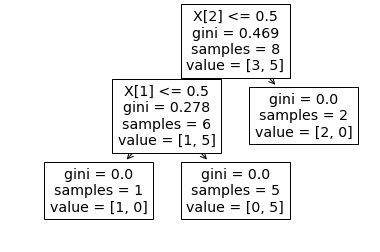

In [32]:
# Dibujo el árbol de decisión

from sklearn.tree import plot_tree

plot_tree(best_model);

In [33]:
vect.get_feature_names()
# X[2]= Japan -> cuento desde el 0
# si esta japon vos a la rana derecha

['beijing', 'chinese', 'japan', 'macao', 'osaka', 'shangai', 'tokyo']

### Busqueda (Grilla) Aleatorizada

- [Randomized Parameter Optimization](https://scikit-learn.org/stable/modules/grid_search.html#randomized-parameter-optimization)

In [37]:
from sklearn.linear_model import SGDClassifier

model = SGDClassifier(random_state=0)

In [40]:
# Defino como voy a samplear

from sklearn.utils.fixes import loguniform
from scipy import stats

param_dist = {
        'loss': [
        'hinge',        # SVM
        'log',          # logistic regression
        #'preceptron',  # perceptron (not supported)
    ],
    'alpha': loguniform(1e-4, 1e0),
}

Podemos muestrear mano con [ParameterSampler](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.ParameterSampler.html):

In [42]:
from sklearn.model_selection import ParameterSampler

# 10 - cuantos samples quiero

for params in ParameterSampler(param_dist, 10, random_state=0):
    print(params)
    model = SGDClassifier(**params, random_state=0)
    #model.fit(...)

{'alpha': 0.01567667719550606, 'loss': 'log'}
{'alpha': 0.23826650493636625, 'loss': 'log'}
{'alpha': 0.015119336467640998, 'loss': 'log'}
{'alpha': 0.031207198770106415, 'loss': 'hinge'}
{'alpha': 0.005627932047415165, 'loss': 'hinge'}
{'alpha': 0.00016859780231705837, 'loss': 'hinge'}
{'alpha': 0.00341795291206101, 'loss': 'hinge'}
{'alpha': 0.1772861933751491, 'loss': 'hinge'}
{'alpha': 0.01871450068624066, 'loss': 'log'}
{'alpha': 0.2209607086872955, 'loss': 'hinge'}


### Busqueda aleatoria + Validación Cruzada

También podemos dejar que Sklearn se encargue de todo con [RandomizedSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html):


In [43]:
from sklearn.model_selection import RandomizedSearchCV

model = SGDClassifier(random_state=0)

# cv=3 -> cuantas Fold o formas de dividir el dataset voy a tener
cv = RandomizedSearchCV(model, param_dist, n_iter=10, cv=3)
cv.fit(X, y);

In [44]:
import pandas as pd
results = cv.cv_results_
df = pd.DataFrame(results)
df[['param_alpha', 'param_alpha', 'mean_test_score', 'std_test_score', 'rank_test_score']]

,param_alpha,param_alpha,mean_test_score,std_test_score,rank_test_score
0,0.0614917,0.0614917,0.888889,0.157135,3
1,0.000142621,0.000142621,0.888889,0.157135,3
2,0.451343,0.451343,0.888889,0.157135,3
3,0.000672146,0.000672146,0.888889,0.157135,3
4,0.115665,0.115665,0.888889,0.157135,3
5,0.000417762,0.000417762,0.888889,0.157135,3
6,0.0299545,0.0299545,1.000000,0.000000,1
7,0.0087031,0.0087031,0.888889,0.157135,3
8,0.0199568,0.0199568,1.000000,0.000000,1
9,0.00226073,0.00226073,0.888889,0.157135,3


In [ ]:
# criterio de navaja de okham: entre dos modelos posibles, uno elige el que sea mas simple de todos.